In [6]:
import sys
import torch
import os
import matplotlib.pyplot as plt
def activation(x):
    return x


current_dir = os.path.dirname(os.path.abspath(os.path.realpath('./')))
parent_dir = os.path.dirname(current_dir)
print(parent_dir)
sys.path.append(parent_dir)
sys.path.append(current_dir)
from ensemble_manager import NetworksLoader, EnsembleManager
from json_handler import JsonHandler
import standard_hyperparams as hp
from FCN3 import HypersphereData

ABS_MENAGERIE_ROOT = os.path.abspath( './FCNX-Ensembling/Menagerie') 
hp.DEVICE='cpu'
def update_dict_paths(config_dict):
    """
    Recursively updates paths in keys of a single dictionary.
    """
    updated_dict = {}
    for key, value in config_dict.items():

        new_value = value
        # If the key is a string and starts with './Menagerie', replace it.
        if isinstance(value, str) and value.startswith('./Menagerie'):
            new_value = value.replace('./Menagerie', ABS_MENAGERIE_ROOT)

        # If the value is a dictionary, recursively call update_dict_paths on it.
        if isinstance(value, dict):
            updated_dict[key] = update_dict_paths(value)
        else:
            updated_dict[key] = new_value
    return updated_dict


Menagerie_dir = os.path.join(current_dir, 'Menagerie')
print(Menagerie_dir)

# Define the specific ensemble directory you want to load
ensemble_dir_name = 'ensemble_FCN3_TRAIN_20250525_173242'
ensemble_full_path = os.path.join(Menagerie_dir, ensemble_dir_name)

# Extract the run_identifier from the ensemble directory name
run_identifier = ensemble_dir_name.replace('ensemble_', '')

print(f"Attempting to load ensemble with run_identifier: {run_identifier}")
print(f"From Menagerie directory: {Menagerie_dir}")
print(f"Full ensemble path: {ensemble_full_path}")

# Initialize EnsembleManager.
# It will load the training_config and manifest if the directory exists.
# Pass the run_identifier and the base menagerie directory.
ensemble_manager = EnsembleManager(
    run_identifier=run_identifier,
    menagerie_dir=Menagerie_dir,
    json_handler=JsonHandler() # Pass an instance of JsonHandler
)
updated_manifest = []

for item_dict in ensemble_manager.training_config['manifest']:
    updated_manifest.append(update_dict_paths(item_dict))
ensemble_manager.training_config['manifest'] = updated_manifest


# Check if the manifest is populated after initialization
if not ensemble_manager.training_config.get('manifest'):
    print(f"Error: No manifest found in {ensemble_full_path}. Please ensure the ensemble directory and its 'training_config.json' are correctly set up, or run the dummy data creation section.")
    sys.exit(1)


config = ensemble_manager.training_config
# Dimensions for the new tensor
num_batches_dim1 = config['num_datsets']
num_batches_dim2 = config['num_ensembles']
num_samples_per_network = 50
output_feature_dim = 1 # As raw_Y is P*1, model output should be 1

# Initialize the tensor to store results: networks x samples x output_dim
# It's (3, 20, 5, 1) as requested.
output_tensor = torch.empty(num_batches_dim1, num_batches_dim2, 1000, output_feature_dim).to(hp.DEVICE)
output_tensor = output_tensor.reshape((60,1000,1))

X = HypersphereData.sample_hypersphere(1000, 15, normalized=False).to(hp.DEVICE)

/home/akiva
/home/akiva/FCNX-Ensembling/Menagerie
Attempting to load ensemble with run_identifier: FCN3_TRAIN_20250525_173242
From Menagerie directory: /home/akiva/FCNX-Ensembling/Menagerie
Full ensemble path: /home/akiva/FCNX-Ensembling/Menagerie/ensemble_FCN3_TRAIN_20250525_173242
Enseble_Dir: /home/akiva/FCNX-Ensembling/Menagerie/ensemble_FCN3_TRAIN_20250525_173242
Ensemble_dir exists


In [7]:
output_tensor.shape

torch.Size([60, 1000, 1])

In [8]:


# Initialize NetworksLoader with the ensemble_manager instance
networks_loader = NetworksLoader(ensemble_manager)
for i, network_info in enumerate(networks_loader):
    model = network_info.get('model').to(hp.DEVICE)
    with torch.no_grad():
        model_output = model(X).detach() # This will be (5, 1)
    
            # Set the slice of the new tensor
        output_tensor[i, :, :] = model_output



/home/akiva/FCNX-Ensembling/ensemble_manager.py:295: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(raw_x_path).to(hp.DEVICE)
/home/akiva/FCNX-Ensembling/en

In [9]:
ensemble_full_path = os.path.join(Menagerie_dir, ensemble_dir_name)
teacher_path = os.path.join(ensemble_full_path, 'teacher_network.pth')
teacher = torch.load(teacher_path)

/tmp/ipykernel_3014141/717829075.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher = torch.load(teacher_path)


In [10]:
model.fc1.weight.shape

torch.Size([32, 15])

Now that I have the teacher, I want to diagonalize the kernel in the basis of orthogonal eigenfunctions. 

In [11]:
params = {}
for name, param in teacher.named_parameters():
    params[name] = param

In [12]:
target = params['fc1.weight'].detach()


In [13]:
target.shape

torch.Size([1, 15])

In [14]:

def find_orthogonal_vectors_pytorch(v: torch.Tensor) -> torch.Tensor:
    """
    Computes d-1 orthonormal vectors orthogonal to a given d-dimensional vector v.

    Args:
        v (torch.Tensor): A 1D PyTorch tensor representing the d-dimensional vector.

    Returns:
        torch.Tensor: A PyTorch tensor where each row is an orthonormal vector
                      orthogonal to v.
    """
    if v.ndim != 1: raise ValueError("Input vector must be 1-dimensional.")
    d = v.shape[0]
    A = v.unsqueeze(0) # Reshape v to (1, d) matrix
    _, _, Vh = torch.linalg.svd(A) # Perform SVD
    return Vh[:, :] # Return the last d-1 rows of Vh (null space basis)


In [15]:
target.squeeze().unsqueeze(0).shape

torch.Size([1, 15])

In [16]:
target

tensor([[ 0.6358,  0.5875, -0.5906,  1.6123,  0.7664, -1.6740, -0.1810, -0.3411,
         -0.5869,  1.8676, -0.2222, -0.5791, -0.0048,  1.6108,  0.6057]],
       device='cuda:0')

In [17]:
import torch

def verify_normalized_target_in_svd(v: torch.Tensor):
    """
    Computes the normalized target vector and verifies it matches
    the first row of the Vh matrix from SVD.

    Args:
        v (torch.Tensor): A 1D PyTorch tensor representing the d-dimensional vector.
    """
    if v.ndim != 1:
        raise ValueError("Input vector must be 1-dimensional.")

    print(f"Original vector v: {v}")
    print(f"Original vector v shape: {v.shape}")

    # 1. Manually compute the normalized target vector
    norm_v = torch.linalg.norm(v)
    normalized_v = v / norm_v
    print(f"\nManually normalized vector (v / ||v||): {normalized_v}")

    # 2. Perform SVD on the reshaped vector
    A = v.unsqueeze(0) # Reshape v to (1, d) matrix
    print(f"Matrix A for SVD (v.unsqueeze(0)): {A}")

    _, _, Vh = torch.linalg.svd(A)
    print(f"\nVh matrix from SVD:\n{Vh}")

    # 3. Extract the first row from Vh
    first_row_Vh = Vh[0, :]
    print(f"\nFirst row of Vh: {first_row_Vh}")

    # 4. Compare the manually normalized vector with the first row of Vh
    # Use torch.isclose for robust comparison due to floating-point precision
    are_they_equal = torch.isclose(normalized_v, first_row_Vh, atol=1e-6)
    
    # Handle the potential sign flip in SVD
    # SVD's sign convention for singular vectors is not unique.
    # The vector could be normalized_v or -normalized_v.
    are_they_equal_flipped_sign = torch.isclose(normalized_v, -first_row_Vh, atol=1e-6)

    if are_they_equal.all():
        print("\nVerification: The manually normalized vector IS EQUAL to the first row of Vh.")
    elif are_they_equal_flipped_sign.all():
        print("\nVerification: The manually normalized vector IS EQUAL to the first row of Vh (with a sign flip).")
        print("This is normal due to SVD's ambiguity in sign convention.")
    else:
        print("\nVerification: Mismatch detected! (This should not happen if the logic is correct)")

# Example Usage:
v1 = target.squeeze()
verify_normalized_target_in_svd(v1)

print("-" * 50)

Original vector v: tensor([ 0.6358,  0.5875, -0.5906,  1.6123,  0.7664, -1.6740, -0.1810, -0.3411,
        -0.5869,  1.8676, -0.2222, -0.5791, -0.0048,  1.6108,  0.6057],
       device='cuda:0')
Original vector v shape: torch.Size([15])

Manually normalized vector (v / ||v||): tensor([ 0.1675,  0.1547, -0.1556,  0.4247,  0.2018, -0.4409, -0.0477, -0.0898,
        -0.1546,  0.4919, -0.0585, -0.1525, -0.0013,  0.4243,  0.1595],
       device='cuda:0')
Matrix A for SVD (v.unsqueeze(0)): tensor([[ 0.6358,  0.5875, -0.5906,  1.6123,  0.7664, -1.6740, -0.1810, -0.3411,
         -0.5869,  1.8676, -0.2222, -0.5791, -0.0048,  1.6108,  0.6057]],
       device='cuda:0')

Vh matrix from SVD:
tensor([[-1.6746e-01, -1.5473e-01,  1.5555e-01, -4.2465e-01, -2.0185e-01,
          4.4090e-01,  4.7680e-02,  8.9838e-02,  1.5457e-01, -4.9190e-01,
          5.8533e-02,  1.5253e-01,  1.2609e-03, -4.2427e-01, -1.5954e-01],
        [-1.5473e-01,  9.7949e-01,  2.0616e-02, -5.6282e-02, -2.6752e-02,
          5.84

In [18]:
from FCN3 import HypersphereData
W = find_orthogonal_vectors_pytorch(target.squeeze()).to(hp.DEVICE)
P = 200
y  = X[:P] @ W
y = y / torch.linalg.norm(y, dim=0).unsqueeze(0)

In [19]:
y  = X[:P] @ W
y = y / torch.linalg.norm(y, dim=0).unsqueeze(0)

In [20]:
means_over_networks = output_tensor.mean(dim=0, keepdim=True).squeeze()
print(means_over_networks.shape)
column_vectors = means_over_networks.unsqueeze(-1) # Adds a dimension at the end: (3, 1, 10, 1)
row_vectors = means_over_networks.unsqueeze(-2)    # Adds a dimension before the last: (3, 1, 1, 10)
print(f'Column: {column_vectors.shape}, Row: {row_vectors.shape}')
mean_outer_product = (column_vectors @ row_vectors).squeeze()
print(f'Mean outer product: {mean_outer_product.shape}')

vectors_squeezed = output_tensor.squeeze(-1) # Shape: (3, 20, 10)
column_vectors = vectors_squeezed.unsqueeze(-1) # Shape: (3, 20, 10, 1)
row_vectors = vectors_squeezed.unsqueeze(-2)    # Shape: (3, 20, 1, 10)
outer_product_matrices = column_vectors @ row_vectors
averaged_outer_products = outer_product_matrices.mean(dim=0)

cov = (averaged_outer_products - mean_outer_product)

torch.Size([1000])
Column: torch.Size([1000, 1]), Row: torch.Size([1, 1000])
Mean outer product: torch.Size([1000, 1000])


In [21]:
cov = torch.cov(output_tensor[:20,:P].squeeze().T)

In [22]:
0
# Get the variances (diagonal elements of the covariance matrix)
variances = torch.diag(cov)

# Get the standard deviations (square root of the variances)
std_devs = torch.sqrt(variances)

# Add a small epsilon to standard deviations to prevent division by zero,
# especially if a variable has zero variance (e.g., all data points are identical)
epsilon = 1e-8
std_devs_safe = std_devs + epsilon

# Create a diagonal matrix with 1 / (standard deviation) on its diagonal.
# This matrix will be used to scale the covariance matrix.
inv_std_devs_diag_matrix = torch.diag(1.0 / std_devs_safe)

# Compute the correlation matrix using matrix multiplication:
# R = D_inv @ C @ D_inv
# where D_inv is the diagonal matrix of inverse standard deviations, and C is the covariance matrix.
correlation_matrix = inv_std_devs_diag_matrix @ cov @ inv_std_devs_diag_matrix

In [23]:
eigvals_matrix = (y.T @ cov @ y )


In [24]:
c = (y.T @ y)

In [25]:
c.shape

torch.Size([15, 15])

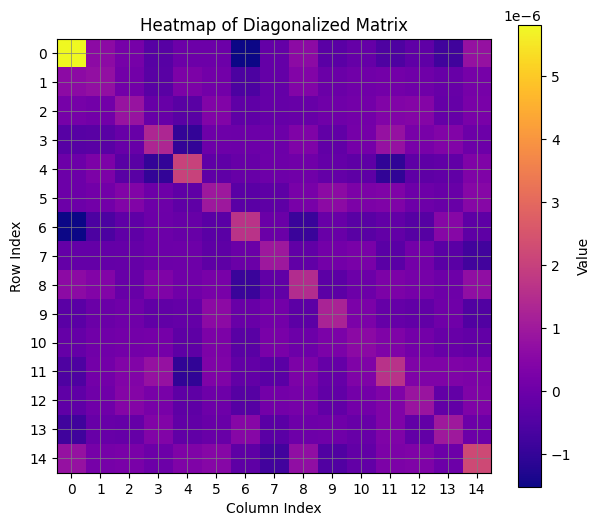

In [29]:
import numpy as np
import matplotlib.pyplot as plt

"""
Plots a heatmap of a diagonalized matrix using only matplotlib.

Args:
    eigvals_matrix (np.ndarray): A 2D NumPy array representing the diagonalized matrix.
                                 Expected to be predominantly zeros off-diagonal.
"""
if eigvals_matrix.ndim != 2:
    raise ValueError("Input matrix must be 2-dimensional.")

plt.figure(figsize=(7, 6))

# Use imshow to create the heatmap
# cmap: 'viridis' (or 'plasma', 'magma', 'hot', 'gray', etc.) for color scheme
# interpolation: 'nearest' for sharp pixels, 'bilinear' for smoother
# origin: 'upper' (default) places (0,0) at top-left, typical for matrices
im = plt.imshow(eigvals_matrix , cmap='plasma', interpolation='nearest')

# Add a color bar to indicate the mapping of values to colors
plt.colorbar(im, label='Value')

plt.title('Heatmap of Diagonalized Matrix')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

# Optionally, add grid lines for better visibility of cells
plt.grid(True, which='both', color='gray', linestyle='-', linewidth=0.5)
plt.xticks(np.arange(eigvals_matrix.shape[1])) # Ensure ticks for each column
plt.yticks(np.arange(eigvals_matrix.shape[0])) # Ensure ticks for each row

plt.show()


In [27]:
lK = torch.diag(eigvals_matrix)
c = (0.0015) / (32) 
lH = (0.0015 )  * lK / (c - lK)

In [28]:
torch.mean(eigvals_matrix - (torch.eye(15,15) * torch.diagonal(eigvals_matrix)) )

tensor(-1.8907e-08)

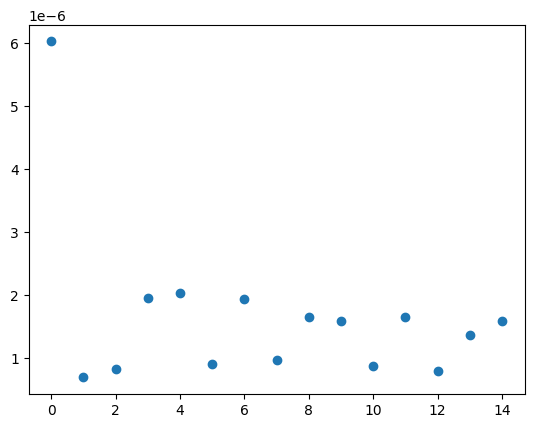

In [226]:
plt.scatter(range(15), torch.diag(eigvals_matrix))

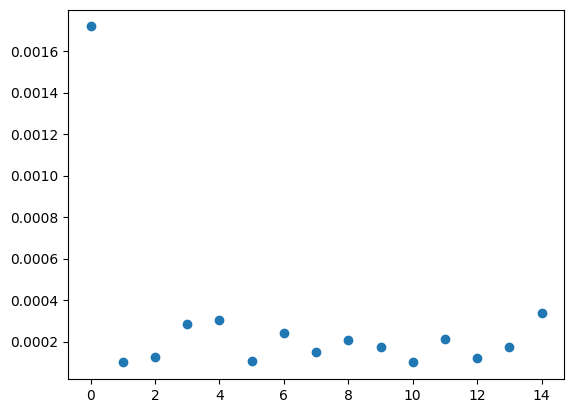

In [153]:
plt.scatter(range(15), lH)

In [227]:
a = torch.mean(lK[1:])

In [228]:
lK[0] / a

tensor(4.5080)

In [251]:
import numpy as np
from scipy.optimize import fsolve, root

def eigenvalue_solver_alternative(params):
    P, k, d, sigma2, N0, N1, chi = params
    initial_guess = np.ones(10) * 1.1 # Initial guess for the eigenvalues




    def eqs(vals):
        lKT, lKhT, lHT, lHhT, lJT, lKp, lKhp, lHp, lHhp, lJp = vals
        c1 = (k/(chi*P))
        c2 = (lHT)/(lHT + k/P)
        c3 = c1*c2
        sigma2_f = c3
        mean2_f = c2**2
        equations = [
            -lKT + sigma2_f + mean2_f,
            -chi/lHT + chi**2 * lKT/lHT**2 - chi**2 * (lHT + k/P)**-2 - lKhT,
            sigma2*(1/chi * sigma2/N1*lKT + lJT**-1)**-1           - lHT,
            N1*(-lJT**-1 + sigma2**-1 * lJT**-2 * lHT)              -lHhT,
            1/(lHT*sigma2/N0 + d/sigma2)                           - lJT, 
            k/(chi*P) * lHp / (lHp + k/P) -                        - lKp,
            -chi/lHp + chi**2 * lKp/lHp**2                        -  lKhp,
            sigma2*(1/chi * sigma2/N1*lKp + lJp**-1)**-1          -  lHp,
            N1*(-lJp**-1 + 1/sigma2 * lJp**-2 * lHp)               - lHhp,
            1/(lHhp * sigma2 / N0 + d/sigma2)                      - lJp
        ]
        return np.array(equations)

    sol = root(eqs, initial_guess, method='lm') # Using the Levenberg-Marquardt algorithm
    if sol.success:
        return sol.x
    else:
        print(f"Alternative solver failed: {sol.message}")
        return None

def eigenvalue_solver(params):
    P, k, d, sigma2, N0, N1, chi = params
    initial_guess = np.ones(5) * 0.1 # Initial guess for the eigenvalues
    """Solves the eigenvalue equations for the empirical kernels."""
    # This line unpacks the values from the tuple
    # l is a shorthand for lambda
    # the next letter is the kernel type.
    # the kernel type is suffixed by h if it is a helper kernel
    # the final letter, T or p signifies whether the eigenvalue is for the target or the perpendicular kernel
    varnamesT = ['lKT', 'lKhT', 'lHT', 'lHhT', 'lJT']
    varnamesp = ['lKp', 'lKhp', 'lHp', 'lHhp', 'lJp']

    def eqsp(vals):
        lKp, lKhp, lHp, lHhp, lJp = vals
        equations = [
            k/(chi*P) * lHp / (lHp + k/P)                           - lKp,
            -chi/lHp + chi**2 * lKp/lHp**2                          - lKhp,
            sigma2*((1/chi) * (sigma2/N1)*lKhp + lJp**-1)**-1       - lHp,
            (-1.0/lJp + 1.0/sigma2 * lHp/(lJp**2))               - lHhp,
            1/(lHhp * sigma2 / N0 + d/sigma2)                       - lJp
        ]

        return np.array(equations)
    def eqsT(vals):
        lKT, lKhT, lHT, lHhT, lJT= vals

        equations = [
            (k/(chi*P))*(lHT)/(lHT + k/P) + (lHT/(lHT+k/P))**2      - lKT,
            -chi/lHT + chi**2 * (lKT/(lHT**2) - (lHT + k/P)**-2)    - lKhT,
            sigma2*((1/chi) * (sigma2/N1)*lKhT + lJT**-1)**-1       - lHT,
            (-1.0/lJT + 1.0/sigma2 * lHT/(lJT**2))               - lHhT,
            1/(lHhT*(sigma2**2)/N0 + d/sigma2)                      - lJT, 
        ]

        return np.array(equations)

    solutionT, infodictT, ierT, mesgT = fsolve(eqsT, initial_guess, full_output=True)
    solutionp, infodictp, ierp, mesgp = fsolve(eqsp, initial_guess, full_output=True)

    if ierT == 1:
        print("-----<<((Eigenvalue Solver))>>-----")
        print("Solution found:")
        # Prints out each variable name and its corresponding value
        for varname, value in zip(varnamesT, solutionT):
            print(f"{varname} = {value:.10f}")
    else:
        print(f"No solution found or convergence issues: {mesgT}")

    if ierp == 1:
        print("-----<<((Eigenvalue Solver))>>-----")
        print("Solution found:")
        # Prints out each variable name and its corresponding value
        for varname, value in zip(varnamesp, solutionp):
            print(f"{varname} = {value:.10f}")
    else:
        print(f"No solution found or convergence issues: {mesgp}")
    return solutionT, solutionp

# Using ens.eigenvalue_solver to solve the analytical eigenvalues
# Assuming 'standard_hyperparams' and 'eos_solvers' would be imported
# if this were part of a larger project.
# For this standalone file, we'll define the parameters directly.

d: int = 50
N0 = 1000
N1 = 1000
T = 1.0

kappa = 1.0
P: int = 300
sigma2 = 1.0

chi =N1
print("kappa/p = ") 
print(kappa/P)
solver_params = [P, kappa, d, sigma2, N0, N1, chi]
solution = eigenvalue_solver(solver_params)
print("-------------")
if solution is not None:
    lKT, lKhT, lHT, lHhT, lJT = solution[0]
    lKp, lKhp, lHp, lHhp, lJp = solution[1]
    print(f"lHhT = {-1.0/lJT + 1.0/sigma2 * lHT/(lJT**2)}")

    Cov_KT = kappa/(chi * P) * (lHT)/( lHT + kappa/P)
    Cov_KhT = - chi / lHT + chi**2 * (lKT / lHT**2)

    Cov_Kp = kappa/(chi * P) * (lHp)/( lHp + kappa/P)
    print(f"Kappa / P = {kappa/P}")
    # WHEN KAPPA/P IS SMALL, THEN THE COVARIANCES ARE NEARLY EXACTLY EQUAL TO ONE ANOTHER
    # The no feature learning being tracked down to the helper fields might be due to 
    # my mixing up covariances and second moments
    Cov_Khp = - chi / lHp + chi**2 * (lKp / lHp**2)
    print(f"Absolute difference of covariance eigenvalues: {Cov_KT - Cov_Kp: .15f}")
    print(f"Kernel Target-Perp Ratio: {Cov_KT/Cov_Kp: .15f}")
    print("\nEigenvalues (from eigenvalue_solver):")
    print(f"Cov KT = {Cov_KT:.12}")
    print(f"lHT = {lHT:.10f}")
    print(f"lHhT = {lHhT:.10f}")
    print(f"lJT = {lJT:.10f}")
    print(f"Cov_Kp = {Cov_Kp:.12}")
    print(f"lHp = {lHp:.10f}")
    print(f"lHhp = {lHhp:.10f}")
    print(f"lJp = {lJp:.10f}")

kappa/p = 
0.0033333333333333335
No solution found or convergence issues: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
-----<<((Eigenvalue Solver))>>-----
Solution found:
lKp = 0.0000028575
lKhp = -42825.7067181327
lHp = 0.0200171278
lHhp = 0.0428624204
lJp = 0.0199999829
-------------
lHhT = 45.23168905120898
Kappa / P = 0.0033333333333333335
Absolute difference of covariance eigenvalues:  0.000000257343597
Kernel Target-Perp Ratio:  1.090059248992121

Eigenvalues (from eigenvalue_solver):
Cov KT = 3.11483574436e-06
lHT = 0.0475189949
lHhT = 45.2316894179
lJT = 0.0231914441
Cov_Kp = 2.85749214755e-06
lHp = 0.0200171278
lHhp = 0.0428624204
lJp = 0.0199999829


## Major Problem

My theory predicts only _very slight_ feature learning, if any at all (in the low figures, likely numerical error). However my experiments do in fact show feature alignment.

**Possibilities** (1) I am misidentifying feature alignment in my data. (2) My calculation of eigenvalues is _wrong_ (3) My equations are _wrong_